# Banking Marketing Targets

https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets

Tushar (tk22994)

Nandu (nrv379)

Mehdi (ma57795)

Sean (sha567)

## Introduction

Given direct marketing campaign data from a Portuguese banking institution, can we predict if a client will subscribe to a term deposit?

A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. These investments usually carry short-term maturities ranging from just a month, to a couple years. A client's money is invested for a certain rate of interest over the whole term.

Term deposits also happen to be a significant source of income for banks. One way that banks will advertise term deposits is through telephonic marketing, which is considered to be one of the more viable marketing methods. However, telephonic marketing campaigns generate large costs through the hiring of call centers. Therefore, it is financially prudent for banks to figure out which customers are the most likely to convert first, and then proceed with targeting them with telephonic marketing after.

## Feature Descriptions

### General Client Data

* age - numeric

* job - categorical

* marital - marital status; categorical

* education - categorical

* default - binary categorical

* balance - average yearly balance; numeric

* housing - has housing loan; binary categorical

* loan - has personal loan; binary categorical

### Data related to last contact of the current campaign

* contact - contact communication type; categorical

* day - last contact day of the month; numerical

* month - last contact month of the year; categorical

* duration - last contact duration, in seconds; numeric

* campaign - number of contacts performed during this campaign and for this client; numeric

* pdays - number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted); numeric

* previous - number of contacts performed before this campaign and for this client; numeric

* poutcome - outcome of the previous marketing campaign; categorical

### Label

* y - has the client subscribed a term deposit?; binary categorical

Ideas:

Class imbalance (SMOTE)

Categorical: one-hot encoding or make numerical (ordinal)?

Look at numerical features

## Data Science

From here, proceed with the data science. Perform data cleaning, data exploration, feature engineering, etc. Use the markdown cells to describe and clarify each part of the process, so that a reader can easily follow along with what you've done.

In [44]:
# import libraries/ standard headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

# pandas version we're using
pd.__version__ 

'1.3.4'

### Data Cleaning

Perform data cleaning. Data cleaning is the process of trying to detect and correct data quality issues

Data quality issues

* missing values
* errors/inconsistent values
* duplicate values
* noise and outliers

In [45]:
# read in the dataset
train_df = pd.read_csv("dataset/train.csv", sep=";")
test_df = pd.read_csv("dataset/test.csv", sep=";")

train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


While printing the .info() shows that we do not have any NULL values, further exploration shows that certain categorical columns have an "unknown" category.

Presented below is the category frequencies for all the categorical features. This brings to light some interesting insights:

1. Were the categories inputted correctly (consistency)?

2. How prevalent is the "unknown" category throughout the dataset?

3. How might we want to engineer our categorical features (one-hot encoding, numericization)?

Looking below, we can see that 0.6% of jobs were unknown, 4.1% of educations were unknown, 28.8% of contact methods were unknown, and 81.7% of poutcomes were unknown.

In [46]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", 'contact',"poutcome"]
for col in categorical_features:
    print(train_df[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print()

blue-collar      21.5%
management       20.9%
technician       16.8%
admin.           11.4%
services          9.2%
retired           5.0%
self-employed     3.5%
entrepreneur      3.3%
unemployed        2.9%
housemaid         2.7%
student           2.1%
unknown           0.6%
Name: job, dtype: object

married     60.2%
single      28.3%
divorced    11.5%
Name: marital, dtype: object

secondary    51.3%
tertiary     29.4%
primary      15.2%
unknown       4.1%
Name: education, dtype: object

no     98.2%
yes     1.8%
Name: default, dtype: object

yes    55.6%
no     44.4%
Name: housing, dtype: object

no     84.0%
yes    16.0%
Name: loan, dtype: object

cellular     64.8%
unknown      28.8%
telephone     6.4%
Name: contact, dtype: object

unknown    81.7%
failure    10.8%
other       4.1%
success     3.3%
Name: poutcome, dtype: object



Since we only have a few unknown jobs, and only a few more unknown educations, and one's education is arguably correlated with one's job, we are going to determine unknown educations through jobs and unknown jobs through educations. To achieve this, we will calculate the education distribution of each job.

In [47]:
# education distribution per job
for job in train_df["job"].unique():
    education_counts = train_df[train_df["job"] == job]["education"].value_counts().sort_index()
    print(job)
    print(education_counts)
    print()

management
primary       294
secondary    1121
tertiary     7801
unknown       242
Name: education, dtype: int64

technician
primary       158
secondary    5229
tertiary     1968
unknown       242
Name: education, dtype: int64

entrepreneur
primary      183
secondary    542
tertiary     686
unknown       76
Name: education, dtype: int64

blue-collar
primary      3758
secondary    5371
tertiary      149
unknown       454
Name: education, dtype: int64

unknown
primary       51
secondary     71
tertiary      39
unknown      127
Name: education, dtype: int64

retired
primary      795
secondary    984
tertiary     366
unknown      119
Name: education, dtype: int64

admin.
primary       209
secondary    4219
tertiary      572
unknown       171
Name: education, dtype: int64

services
primary       345
secondary    3457
tertiary      202
unknown       150
Name: education, dtype: int64

self-employed
primary      130
secondary    577
tertiary     833
unknown       39
Name: education, dtype: int

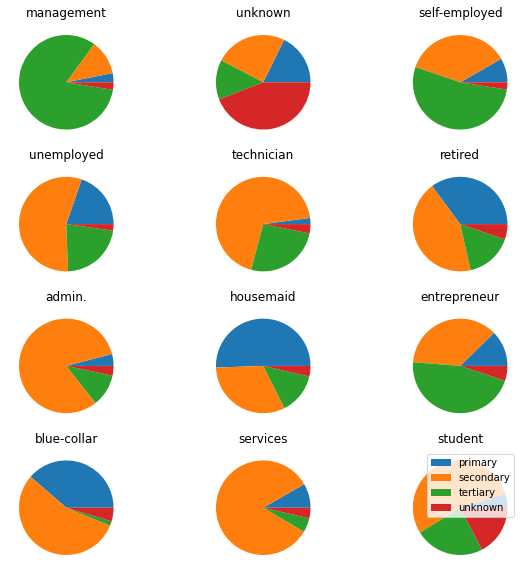

In [48]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
ij = 0
i = 0
j = 0
for job in train_df["job"].unique():
    education_counts = train_df[train_df["job"] == job]["education"].value_counts().sort_index()
    patches, texts = axs[i,j].pie(education_counts)
    axs[i,j].set_title(job)
    plt.legend(patches, ['primary','secondary','tertiary','unknown'], loc="best")
    ij += 1
    i = ij % 4
    j = ij % 3

In [49]:
education_percentages = dict()
for job in train_df["job"].unique():
    education_counts = train_df[train_df["job"] == job]["education"].value_counts()
    total = education_counts["tertiary"] + education_counts["secondary"] + education_counts["primary"]
    education_percentages[job] = {}
    tertiary_percentage = education_counts["tertiary"] / total
    secondary_percentage = education_counts["secondary"] / total
    primary_percentage = education_counts["primary"] / total
    total_unknown = education_counts["unknown"]
    education_percentages[job]["tertiary"] = math.ceil(tertiary_percentage * total_unknown)
    education_percentages[job]["secondary"] = math.ceil(secondary_percentage * total_unknown)
    education_percentages[job]["primary"] = math.ceil(primary_percentage * total_unknown)
for index, row in train_df.iterrows():
    if row["education"] == "unknown":
        if education_percentages[row["job"]]["tertiary"] != 0:
            train_df.loc[index, ["education"]] = "tertiary"
            education_percentages[row["job"]]["tertiary"] -= 1
        elif education_percentages[row["job"]]["secondary"] != 0:
            train_df.loc[index, ["education"]] = "secondary"
            education_percentages[row["job"]]["secondary"] -=1
        else:
            train_df.loc[index, ["education"]] = "primary"
    else:
        continue


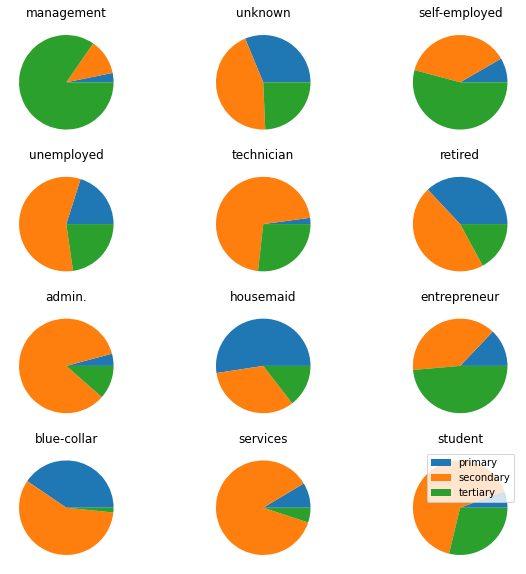

In [50]:
# after replacement
fig, axs = plt.subplots(4,3, figsize=(10,10))
ij = 0
i = 0
j = 0
for job in train_df["job"].unique():
    education_counts = train_df[train_df["job"] == job]["education"].value_counts().sort_index()
    patches, texts = axs[i,j].pie(education_counts)
    axs[i,j].set_title(job)
    plt.legend(patches, ['primary','secondary','tertiary','unknown'], loc="best")
    ij += 1
    i = ij % 4
    j = ij % 3

In [51]:
for education in train_df["education"].unique():
    job_counts = train_df[train_df["education"] == education]["job"].value_counts()
    print(education)
    print(job_counts)
    print()

train_df.loc[(train_df.job == "unknown") & (train_df.education == "tertiary"), "job"] = "management"
train_df.loc[(train_df.job == "unknown") & (train_df.education == "secondary"), "job"] = "blue-collar"
train_df.loc[(train_df.job == "unknown") & (train_df.education == "primary"), "job"] = "blue-collar"

print(train_df[train_df.job == 'unknown'])

tertiary
management       8006
technician       2033
self-employed     855
entrepreneur      723
admin.            592
retired           387
unemployed        296
student           270
services          210
housemaid         180
blue-collar       157
unknown            70
Name: job, dtype: int64

secondary
blue-collar      5634
technician       5402
admin.           4364
services         3587
management       1151
retired          1039
unemployed        745
student           615
self-employed     592
entrepreneur      572
housemaid         410
unknown           128
Name: job, dtype: int64

primary
blue-collar      3941
retired           838
housemaid         650
services          357
management        301
unemployed        262
admin.            215
entrepreneur      192
technician        162
self-employed     132
unknown            90
student            53
Name: job, dtype: int64

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, mon

Looking at the pdays column, we notice that the majority of rows actually have -1 for pdays. This means that a minority of rows have an actual ordinal numerical value for pdays. Therefore, when we get to feature engineering, we can consider turning this into a binary categorical variable (yes/no).

In [52]:
print(train_df[train_df['pdays'] == -1]['pdays'].count())
print(train_df[train_df['pdays'] != -1]['pdays'].count())

36954
8257


What about our label?

**Write about how we will use SMOTE because of class imbalances (Slides #6)**

In [53]:
train_df['y'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

no     88.3%
yes    11.7%
Name: y, dtype: object

In [54]:
contact_mode = train_df["contact"].mode()
train_df["contact"].replace(["unknown"], contact_mode,inplace = True)
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,may,92,1,-1,0,unknown,no
4,33,management,single,tertiary,no,1,no,no,cellular,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [55]:
# maybe we should just drop this column???
train_df["poutcome"].replace(["unknown"], "other",inplace = True)
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,other,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,other,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,other,no
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,may,92,1,-1,0,other,no
4,33,management,single,tertiary,no,1,no,no,cellular,5,may,198,1,-1,0,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,other,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,other,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,other,no


replace pdays -1 with max (of pdays)

In [56]:
# max_pdays = train_df['pdays'].max()
# train_df['pdays'].replace([-1], max_pdays, inplace = True)
# train_df

### Exploratory Data Analysis (EDA)

#### Noise vs Outliers

* outliers - anomalous objects with characteristics that are different from, or unusual with respect to, the rest of the data
* noise - random errors in the data

<AxesSubplot:xlabel='education', ylabel='age'>

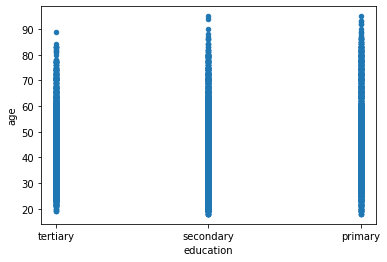

In [57]:
# create a scatterplot between age and job
train_df.plot.scatter('education', 'age')

<AxesSubplot:xlabel='job', ylabel='age'>

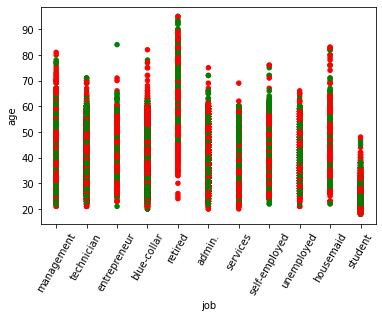

In [58]:
colors = {'no': 'red', 'yes': 'green'}
train_df.plot.scatter('job', 'age', c=train_df['y'].map(colors), rot=60)

retired folks seem more likely to invest in low risk securities!

### Feature Engineering

feature transformation or feature creation

#### feature engineer day of week column

In [59]:
temp = pd.Timestamp('2022-04-17')
print(temp.dayofweek, temp.day_name())
print("Can you see this")
# create year column
curYear = 2008
janStretch = False
yearList = []
for ind in train_df.index:
    if train_df['month'][ind] == 'jan' and not janStretch:
        janStretch = True
        curYear += 1  
    elif train_df['month'][ind] != 'jan':
        janStretch = False
    yearList.append(curYear) 
train_df['year'] = yearList

# create day of week column
# create a list then add to dataframe train_df
temp = pd.Timestamp('2022-4-5')
monthToNum = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
                'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}

dayOfWkList = []
for ind in train_df.index:
    year = train_df['year'][ind]
    month = train_df['month'][ind]
    day = train_df['day'][ind]
    timestampStr = str(year) + '-' + str(month) + '-' + str(day)
    dayOfWk = pd.Timestamp(timestampStr)
    dayOfWkList.append(dayOfWk.day_of_week)
train_df['dayOfWk'] = dayOfWkList
train_df

6 Sunday
Can you see this


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,year,dayOfWk
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,other,no,2008,0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,other,no,2008,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,other,no,2008,0
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,may,92,1,-1,0,other,no,2008,0
4,33,management,single,tertiary,no,1,no,no,cellular,5,may,198,1,-1,0,other,no,2008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,other,yes,2010,2
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,other,yes,2010,2
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,2010,2
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,other,no,2010,2


#### feature engineer previously contacted and not column

In [60]:
new_pdays = np.where(train_df['pdays'] == -1, 0, 1)
train_df['pdays_cat'] = new_pdays
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,year,dayOfWk,pdays_cat
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,other,no,2008,0,0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,other,no,2008,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,other,no,2008,0,0
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,may,92,1,-1,0,other,no,2008,0,0
4,33,management,single,tertiary,no,1,no,no,cellular,5,may,198,1,-1,0,other,no,2008,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,other,yes,2010,2,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,other,yes,2010,2,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,2010,2,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,other,no,2010,2,0


#### feature engineer 
one-hot encoding: turn nominal categorical data to numerical data 
while not mathematically imply any ordinal relationship between the classes

In [61]:
# one hot encoding for job column
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
# makes a dataset. each column is a value in the job column from the original dataset. the new cloumns are sorted based on the values!
job_encoder = pd.DataFrame(encoder.fit_transform(train_df[['job']]).toarray())
# get the list of values in the job column and sort them so you can change the names
list_of_jobs = train_df["job"].unique()
list_of_jobs.sort()
job_encoder.columns = list_of_jobs
train_df = train_df.join(job_encoder)
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,management,single,tertiary,no,1,no,no,cellular,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

Then move on to the modeling, and continue to use the markdown cells to walk a reader through your process. 

#### svm, neural nets, look at paper

## Results

Finally, display and analyze your results.

### Conclusion

Include a final conclusion - this may be an analysis of which model worked best, or which feature engineering worked best, or it may be any interesting insights you discovered about your data, or anything at all that you want to conclude from your work. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=825dc3e6-d277-4188-bb22-3ec9a91d5af7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>